<a href="https://colab.research.google.com/github/duatama2004/duatama2004/blob/main/Tugas_duatama_dan_munif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Identifikasi Penyakit Daun Tanaman Jagung dengan CNN dan YOLO
Dataset: Wilayah Ponorogo
"""

import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Activation, Dropout, BatchNormalization)
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB7
from keras.callbacks import EarlyStopping

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Tampilkan isi folder
import os
path = '/content/drive/MyDrive/Komputasi pararel UAS duatama/data jagung'
if os.path.exists(path):
    print("Folder ditemukan! Berikut isi folder:")
    print(os.listdir(path))
else:
    print("Folder tidak ditemukan!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder ditemukan! Berikut isi folder:
['Sehat', 'gray_leaf_spot', 'common_rust', 'blight']


In [ ]:
data_dir = '/content/drive/MyDrive/Komputasi pararel UAS duatama/data jagung'

In [ ]:
# Membuat Dataframe dari Dataset
def generate_data_paths(data_dir):
    filepaths, labels = [], []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return filepaths, labels

filepaths, labels = generate_data_paths(data_dir)

def create_df(filepaths, labels):
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

df = create_df(filepaths, labels)

In [ ]:
# Menampilkan Informasi Dataset
print(f"Total gambar: {len(df)}")
print(f"Jumlah kelas: {df['labels'].nunique()}")
print(df['labels'].value_counts())


Total gambar: 441
Jumlah kelas: 4
labels
Sehat             117
gray_leaf_spot    108
common_rust       108
blight            108
Name: count, dtype: int64


In [ ]:
# Split Dataset
train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df['labels'], random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['labels'], random_state=42)


In [ ]:
# Data Augmentation
batch_size = 32
img_size = (224, 224)
channels = 3

def scalar(img):
    return img / 255.0

train_gen = ImageDataGenerator(preprocessing_function=scalar,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                brightness_range=[0.4, 1.5],
                                zoom_range=0.3,
                                horizontal_flip=True)

valid_gen = ImageDataGenerator(preprocessing_function=scalar)

test_gen = ImageDataGenerator(preprocessing_function=scalar)

train_data = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           shuffle=True, batch_size=batch_size)

valid_data = valid_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           shuffle=False, batch_size=batch_size)

test_data = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          shuffle=False, batch_size=batch_size)

Found 308 validated image filenames belonging to 4 classes.
Found 66 validated image filenames belonging to 4 classes.
Found 67 validated image filenames belonging to 4 classes.


In [ ]:
# CNN Model dengan EfficientNetB7
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')
base_model.trainable = False


In [ ]:
#Membuat model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training Model
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=30,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 186s 15s/step - accuracy: 0.2418 - loss: 9.2882 - val_accuracy: 0.2576 - val_loss: 16.8190
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 12s/step - accuracy: 0.2737 - loss: 8.4093 - val_accuracy: 0.2424 - val_loss: 13.9231
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 12s/step - accuracy: 0.2505 - loss: 7.8170 - val_accuracy: 0.2576 - val_loss: 11.2479
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 12s/step - accuracy: 0.2714 - loss: 7.2209 - val_accuracy: 0.2576 - val_loss: 12.4321
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 147s 15s/step - accuracy: 0.2543 - loss: 7.2202 - val_accuracy: 0.2576 - val_loss: 8.7069
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 126s 12s/step - accuracy: 0.3028 - loss: 6.8675 - val_accuracy: 0.2424 - val_loss: 8.8402
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 13s/step - accuracy: 0.2235 - loss: 6.8131 - val_accuracy: 0.2576 - val_loss: 8.2700
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.2410 - loss: 6.7328 - val_accuracy: 0.2424 - 

In [ ]:
# Evaluasi Model
results = model.evaluate(test_data)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.2483 - loss: 6.0468
Test Loss: 6.0473, Test Accuracy: 0.2388


In [ ]:
# Simpan Model
model.save('/content/cnn_model_corn_disease.h5')

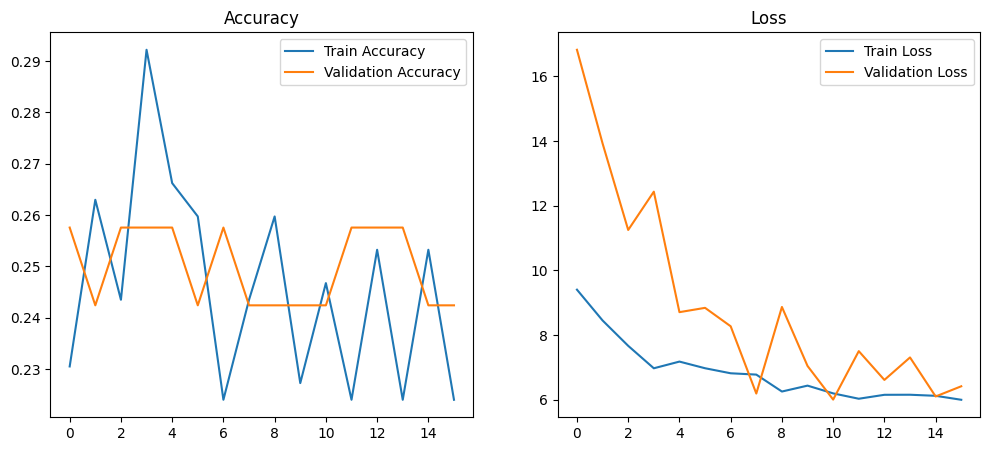

In [ ]:
# Visualisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.1/910.1 kB 14.5 MB/s eta 0:00:00


In [ ]:
# Penambahan YOLO untuk Deteksi Penyakit Daun Jagung
import torch
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 1. Inisialisasi Model YOLOv5
model_yolo = YOLO('yolov5s.pt')  # Menggunakan model YOLOv5 pre-trained

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 143MB/s] 


In [ ]:
# 2. Konfigurasi Dataset untuk YOLO
# Dataset harus berformat YOLO: folder berisi gambar dan file label (bounding box)
yolo_data_path = '/content/drive/MyDrive/Komputasi pararel UAS duatama/data jagung'

In [ ]:
import os
import pandas as pd
from shutil import copyfile

# Path dataset CNN dan tujuan YOLO
cnn_data_dir = '/content/drive/MyDrive/Komputasi pararel UAS duatama/data jagung'
yolo_data_dir = '/content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo'

# Membuat struktur folder YOLO
os.makedirs(f"{yolo_data_dir}/images/train", exist_ok=True)
os.makedirs(f"{yolo_data_dir}/images/val", exist_ok=True)
os.makedirs(f"{yolo_data_dir}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_data_dir}/labels/val", exist_ok=True)

# Membagi dataset menjadi train dan val
from sklearn.model_selection import train_test_split

filepaths, labels = [], []
for class_name in os.listdir(cnn_data_dir):
    class_path = os.path.join(cnn_data_dir, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            filepaths.append(os.path.join(class_path, file))
            labels.append(class_name)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
train_df, val_df = train_test_split(df, train_size=0.8, stratify=df['labels'], random_state=42)

# Membuat dictionary mapping kelas ke class_id
classes = sorted(df['labels'].unique())
class_mapping = {cls: idx for idx, cls in enumerate(classes)}

# Fungsi untuk membuat file bounding box dummy
def create_dummy_bounding_box(image_path, class_id, label_path):
    # Contoh: Semua bounding box mencakup seluruh gambar (0.5, 0.5, 1, 1)
    with open(label_path, 'w') as f:
        f.write(f"{class_id} 0.5 0.5 1 1\n")

# Proses konversi ke format YOLO
for split, split_df in [('train', train_df), ('val', val_df)]:
    for _, row in split_df.iterrows():
        # Salin gambar ke folder YOLO
        image_dest = os.path.join(yolo_data_dir, f"images/{split}/{os.path.basename(row['filepaths'])}")
        copyfile(row['filepaths'], image_dest)

        # Buat file label (bounding box dummy)
        class_id = class_mapping[row['labels']]
        label_dest = os.path.join(yolo_data_dir, f"labels/{split}/{os.path.splitext(os.path.basename(row['filepaths']))[0]}.txt")
        create_dummy_bounding_box(row['filepaths'], class_id, label_dest)

# Buat file data.yaml
yaml_content = f"""
path: {yolo_data_dir}
train: images/train
val: images/val
nc: {len(classes)}
names: {classes}
"""
with open(f"{yolo_data_dir}/data.yaml", 'w') as f:
    f.write(yaml_content)

print(f"Dataset YOLO berhasil dibuat di: {yolo_data_dir}")


Dataset YOLO berhasil dibuat di: /content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov5s.pt')  # Model YOLO pre-trained
model.train(data=f"{yolo_data_dir}/data.yaml", epochs=50, imgsz=640, batch=16)


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half

100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics

train: Scanning /content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo/labels/train... 352 images, 0 backgrounds, 0 corrupt: 100%|██████████| 352/352 [00:04<00:00, 75.20it/s] 


train: New cache created: /content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo/labels/val... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<00:00, 104.08it/s]


val: New cache created: /content/drive/MyDrive/Komputasi pararel UAS duatama/data_jagung_yolo/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.4712       2.08      1.153         54        640: 100%|██████████| 22/22 [08:24<00:00, 22.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.27s/it]

                   all         89         89      0.553       0.46      0.518      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.2183       1.16     0.9674         45        640: 100%|██████████| 22/22 [08:12<00:00, 22.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.30s/it]

                   all         89         89      0.685      0.732      0.797      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.2576      1.011     0.9851         40        640: 100%|██████████| 22/22 [08:08<00:00, 22.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.04s/it]

                   all         89         89      0.486      0.637      0.516      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.2578     0.9342     0.9879         50        640: 100%|██████████| 22/22 [08:08<00:00, 22.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.74s/it]

                   all         89         89      0.561      0.731      0.629      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.2622     0.9385     0.9822         52        640: 100%|██████████| 22/22 [08:05<00:00, 22.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.38s/it]

                   all         89         89      0.477      0.582      0.599      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.2784      1.047      1.006         50        640: 100%|██████████| 22/22 [08:07<00:00, 22.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.84s/it]

                   all         89         89      0.576      0.806      0.718      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.2705     0.9638     0.9849         47        640: 100%|██████████| 22/22 [08:07<00:00, 22.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.51s/it]

                   all         89         89      0.374      0.746      0.569      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.2634     0.8588     0.9782         48        640: 100%|██████████| 22/22 [08:25<00:00, 22.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.82s/it]

                   all         89         89      0.597      0.852      0.809      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.2686     0.8599     0.9872         43        640: 100%|██████████| 22/22 [08:07<00:00, 22.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.94s/it]

                   all         89         89      0.493      0.752      0.625      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.2221     0.8045     0.9621         50        640: 100%|██████████| 22/22 [07:54<00:00, 21.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.49s/it]

                   all         89         89      0.464      0.728      0.651      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.2311     0.9007     0.9652         44        640: 100%|██████████| 22/22 [07:58<00:00, 21.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.59s/it]

                   all         89         89       0.48       0.69      0.563      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.2126     0.8293      0.955         44        640: 100%|██████████| 22/22 [08:10<00:00, 22.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.92s/it]

                   all         89         89      0.863      0.886      0.932      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.1898     0.7575     0.9337         50        640: 100%|██████████| 22/22 [08:16<00:00, 22.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.90s/it]

                   all         89         89      0.696      0.736      0.813      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.1816     0.7399     0.9349         54        640: 100%|██████████| 22/22 [08:13<00:00, 22.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.74s/it]

                   all         89         89      0.538      0.888      0.787      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.1903     0.7058      0.946         52        640: 100%|██████████| 22/22 [08:14<00:00, 22.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.25s/it]

                   all         89         89      0.895       0.82      0.922      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.1765     0.7114     0.9273         49        640: 100%|██████████| 22/22 [08:15<00:00, 22.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.25s/it]

                   all         89         89       0.66        0.9      0.924      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.1651      0.639     0.9208         51        640: 100%|██████████| 22/22 [08:13<00:00, 22.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.01s/it]

                   all         89         89      0.927      0.803      0.922      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.1712     0.6937     0.9207         52        640: 100%|██████████| 22/22 [08:14<00:00, 22.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.98s/it]

                   all         89         89      0.758      0.725      0.802      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.1501     0.6524      0.913         49        640: 100%|██████████| 22/22 [08:12<00:00, 22.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.63s/it]

                   all         89         89      0.591      0.864      0.902      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.1613     0.5988     0.9251         44        640: 100%|██████████| 22/22 [08:11<00:00, 22.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.54s/it]

                   all         89         89      0.659      0.812      0.832      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.1606     0.6437     0.9232         50        640: 100%|██████████| 22/22 [08:11<00:00, 22.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.84s/it]

                   all         89         89      0.868      0.656      0.859      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.1446     0.5975     0.9214         43        640: 100%|██████████| 22/22 [08:11<00:00, 22.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.91s/it]

                   all         89         89      0.907      0.902      0.962      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.1368      0.558     0.9174         42        640: 100%|██████████| 22/22 [08:06<00:00, 22.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.95s/it]

                   all         89         89      0.873      0.886      0.948      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.1347     0.5913     0.9099         55        640: 100%|██████████| 22/22 [07:59<00:00, 21.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]

                   all         89         89      0.922      0.879      0.963      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.1337     0.5346     0.9045         51        640: 100%|██████████| 22/22 [08:02<00:00, 21.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.26s/it]

                   all         89         89      0.931        0.8      0.938      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.1261     0.5652     0.9016         42        640: 100%|██████████| 22/22 [08:02<00:00, 21.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.81s/it]

                   all         89         89       0.87      0.825      0.919      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.1143      0.548     0.8978         55        640: 100%|██████████| 22/22 [08:03<00:00, 21.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.99s/it]

                   all         89         89      0.924      0.801      0.943      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.1225     0.5354     0.9026         53        640: 100%|██████████| 22/22 [07:57<00:00, 21.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.17s/it]

                   all         89         89      0.922       0.86      0.952      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.1164     0.4963     0.9029         51        640: 100%|██████████| 22/22 [07:55<00:00, 21.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.47s/it]

                   all         89         89       0.91      0.925      0.965      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.1177     0.4673     0.9128         42        640: 100%|██████████| 22/22 [07:46<00:00, 21.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.29s/it]

                   all         89         89      0.904      0.888      0.965      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.1117     0.5024     0.9034         52        640: 100%|██████████| 22/22 [08:01<00:00, 21.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.65s/it]

                   all         89         89      0.974      0.862      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      0.107     0.4539     0.8886         56        640: 100%|██████████| 22/22 [08:03<00:00, 21.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.22s/it]

                   all         89         89      0.733       0.85      0.901      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.1116     0.5503        0.9         49        640: 100%|██████████| 22/22 [08:03<00:00, 21.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.41s/it]

                   all         89         89      0.896      0.948      0.965       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.1107     0.5099     0.8879         54        640: 100%|██████████| 22/22 [08:08<00:00, 22.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.68s/it]

                   all         89         89      0.869      0.944      0.965      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.1023     0.4529     0.8908         54        640: 100%|██████████| 22/22 [08:11<00:00, 22.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.98s/it]

                   all         89         89       0.83      0.931      0.938      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.1068     0.4461     0.9017         43        640: 100%|██████████| 22/22 [08:11<00:00, 22.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.46s/it]

                   all         89         89      0.833      0.974      0.952      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      0.101      0.426     0.9035         50        640: 100%|██████████| 22/22 [08:14<00:00, 22.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.58s/it]

                   all         89         89      0.918      0.915      0.961       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G    0.08903     0.4576     0.8955         53        640: 100%|██████████| 22/22 [08:19<00:00, 22.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.70s/it]

                   all         89         89       0.88      0.942       0.95      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G    0.09035     0.4197      0.891         43        640: 100%|██████████| 22/22 [08:18<00:00, 22.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.89s/it]

                   all         89         89      0.841      0.954       0.94      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G    0.09425     0.3902     0.9078         50        640: 100%|██████████| 22/22 [08:17<00:00, 22.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.77s/it]

                   all         89         89      0.901      0.905      0.971      0.963


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.1683     0.6565     0.9766         16        640: 100%|██████████| 22/22 [08:11<00:00, 22.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.37s/it]

                   all         89         89       0.87      0.989      0.976      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G    0.09967     0.4359     0.9036         16        640: 100%|██████████| 22/22 [08:12<00:00, 22.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.09s/it]

                   all         89         89      0.933      0.896      0.957      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G    0.09009     0.2875     0.9038         16        640: 100%|██████████| 22/22 [08:07<00:00, 22.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.83s/it]

                   all         89         89       0.88      0.943      0.963      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G    0.08454     0.3032     0.8913         16        640: 100%|██████████| 22/22 [07:59<00:00, 21.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.73s/it]

                   all         89         89      0.947      0.847      0.956      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G    0.07805     0.3248     0.8915         16        640: 100%|██████████| 22/22 [08:00<00:00, 21.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.62s/it]

                   all         89         89      0.919      0.887      0.958      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G    0.07658     0.3077     0.8975         16        640: 100%|██████████| 22/22 [08:03<00:00, 21.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.96s/it]

                   all         89         89      0.889      0.953      0.974      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G    0.06892     0.2639     0.8879         16        640: 100%|██████████| 22/22 [08:06<00:00, 22.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.62s/it]

                   all         89         89      0.864      0.984      0.977      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G    0.06531     0.2402        0.9         16        640: 100%|██████████| 22/22 [08:06<00:00, 22.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.42s/it]

                   all         89         89      0.953       0.89      0.967      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.0606     0.2646     0.9099         16        640: 100%|██████████| 22/22 [07:59<00:00, 21.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.37s/it]

                   all         89         89       0.83      0.974      0.955       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G    0.06261     0.2852      0.902         16        640: 100%|██████████| 22/22 [08:03<00:00, 21.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.26s/it]

                   all         89         89      0.826      0.977      0.955      0.949



50 epochs completed in 7.369 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (AMD EPYC 7B12)
YOLOv5s summary (fused): 193 layers, 9,113,084 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:38<00:00, 12.75s/it]


                   all         89         89      0.871      0.989      0.976      0.972
                 Sehat         23         23      0.971          1      0.995      0.995
                blight         22         22      0.724          1       0.96      0.945
           common_rust         22         22      0.933          1      0.995      0.995
        gray_leaf_spot         22         22      0.854      0.955      0.954      0.954
Speed: 1.5ms preprocess, 408.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d9f202c3190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0